# image-classifier

based on this [Kaggle Notebook](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset).

* Classify 15 different types of vegetables using transfer learning. 

In [1]:
import os
import abcli
from abcli import string
from abcli.plugins.gpu import validate
import image_classifier
from abcli import logging
import logging

logger = logging.getLogger(__name__)

logger.info(f"using {abcli.fullname()}, {image_classifier.name}-{image_classifier.version}")
logger.info(f"{os.environ.get('abcli_object_name')} - built on {string.pretty_date()}")

validate();

using abcli-1.1.463-main, image_classifier-1.1.23
2022-07-06-11-49-48-05372 - built on 06 July 2022, 12:51:25
TensorFlow: 2.3.2
1 GPU(s) available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')].


# Import data and helper documents

In [2]:
import tensorflow as tf
import os

In [3]:
list_dir = os.listdir('.')

if 'vegetable-images.zip?dl=0' not in list_dir:
  # fetch images
  !wget https://www.dropbox.com/s/lbqzfovdqs02nr8/vegetable-images.zip?dl=0
  # fetch helper documents
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


In [4]:
# Let's create a function tgo compare training histories
def compare_histories(original_history, new_history, initial_epochs=5):
  """
  Compares two TensorFlow History Objects
  """

  # Get original history measurements
  acc = original_history.history['accuracy']
  loss = original_history.history['loss']
  
  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history['val_loss']

  # Combine original history metrics with new history metrics
  total_acc = acc + new_history.history['accuracy']
  total_loss = loss + new_history.history['loss']
  
  total_val_acc = val_acc + new_history.history['val_accuracy'] 
  total_val_loss = val_loss + new_history.history['val_loss']

  # Make plot for accuracy
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label='Trainig Acc')
  plt.plot(total_val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and validation accuracy')

  # Make plot for loss
  plt.figure(figsize=(8,8))

  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label='Trainig Loss')
  plt.plot(total_val_loss, label='Validation loss')
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and validation loss')

In [5]:
from helper_functions import plot_loss_curves, unzip_data, walk_through_dir

In [6]:
dir_list = os.listdir('.')

# unzip data if docs don't exist yet
if 'train_30' not in dir_list:
  unzip_data('vegetable-images.zip?dl=0')

In [7]:
# Check some of the directories
walk_through_dir('validation')

There are 15 directories and 0 images in 'validation'.
There are 0 directories and 200 images in 'validation/Carrot'.
There are 0 directories and 200 images in 'validation/Cabbage'.
There are 0 directories and 200 images in 'validation/Cucumber'.
There are 0 directories and 200 images in 'validation/Bottle_Gourd'.
There are 0 directories and 200 images in 'validation/Bean'.
There are 0 directories and 200 images in 'validation/Bitter_Gourd'.
There are 0 directories and 200 images in 'validation/Papaya'.
There are 0 directories and 200 images in 'validation/Capsicum'.
There are 0 directories and 200 images in 'validation/Potato'.
There are 0 directories and 200 images in 'validation/Cauliflower'.
There are 0 directories and 200 images in 'validation/Broccoli'.
There are 0 directories and 200 images in 'validation/Brinjal'.
There are 0 directories and 200 images in 'validation/Tomato'.
There are 0 directories and 200 images in 'validation/Pumpkin'.
There are 0 directories and 200 images 

# Preprocess data

Lets setup our images and create functions to create new models with the same architecture


## Create image datasets from directories

In [8]:
train_30_percent = tf.keras.preprocessing.image_dataset_from_directory(
  'train_30',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

train_data = tf.keras.preprocessing.image_dataset_from_directory(
  'train',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

test_data = tf.keras.preprocessing.image_dataset_from_directory(
  'test',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(
  'validation',
  image_size = (224, 224),
  label_mode = 'categorical',
  seed = 42
)

Found 4500 files belonging to 15 classes.
Found 15000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.
Found 3000 files belonging to 15 classes.


## Create data augmentation layer

In [9]:
data_augmentation_dial = 0.2
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomZoom(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomHeight(data_augmentation_dial),
  tf.keras.layers.experimental.preprocessing.RandomWidth(data_augmentation_dial),
  # tf.keras.layers.experimental.preprocessing.Resizing(224, 224),
  # tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
], name='data_augmentation_layer')

## Create function to visualize images (normal/augmented)

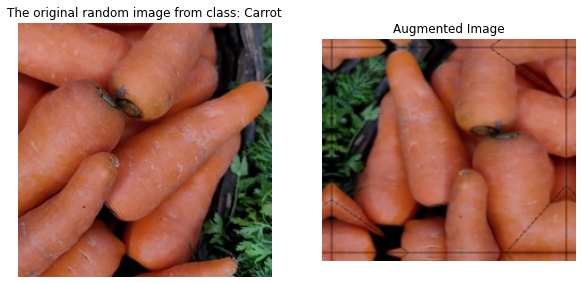

In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Set random states
# random.seed(42)
# tf.random.set_seed(42)

def view_random_image():
  target_class = random.choice(train_data.class_names)
  target_dir = 'train/' + target_class
  random_image = random.choice(os.listdir(target_dir))
  random_image_path = target_dir + '/' + random_image

  plt.figure(figsize=(10,15))

  # Read in random image
  image = mpimg.imread(random_image_path)
  plt.subplot(1, 2, 1)
  plt.imshow(image)
  plt.title(f'The original random image from class: {target_class}')
  plt.axis(False)


  # Now plot the augmented random image
  augmented_image = data_augmentation(tf.expand_dims(image, axis=0), training=True)
  plt.subplot(1, 2, 2)
  plt.imshow(tf.squeeze(augmented_image/255.))
  plt.title(f'Augmented Image')
  plt.axis(False)

view_random_image()

## Creating checkpoint callback


In [11]:
checkpoint_path = 'vegetables_checkpoint_30_percent/checkpoint.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights=True,
    save_best_only=True,
    save_freq='epoch',
    verbose=1
)

# Create Feature Extraction models



## Feature Extraction base model

In [12]:
from numpy import e
from tensorflow.keras import layers


# Setup input shape and base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create input layer
inputs = layers.Input(shape=input_shape, name = 'input_layer')

x = data_augmentation(inputs)

x = base_model(x, training=False)

# Extract features from model
x = layers.GlobalAveragePooling2D (name='global_average_pooling_layer')(x)

outputs = layers.Dense(15, activation='softmax', name='output_layer')(x)

## Model 1: Feature Extraction

Epoch 1/5
141/141 [==============================] - ETA: 0s - loss: 0.6958 - accuracy: 0.8660
Epoch 00001: val_loss improved from inf to 0.19086, saving model to vegetables_checkpoint_30_percent/checkpoint.ckpt


From /home/ubuntu/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
From /home/ubuntu/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/tensorflow/python/training/tracking/tracking.py:111: Layer.updates (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Assets written to: vegetables_checkpoint_30_percent/checkpoint.ckpt/assets


141/141 [==============================] - 61s 436ms/step - loss: 0.6958 - accuracy: 0.8660 - val_loss: 0.1909 - val_accuracy: 0.9733
Epoch 2/5
141/141 [==============================] - ETA: 0s - loss: 0.1543 - accuracy: 0.9749
Epoch 00002: val_loss improved from 0.19086 to 0.09805, saving model to vegetables_checkpoint_30_percent/checkpoint.ckpt


Assets written to: vegetables_checkpoint_30_percent/checkpoint.ckpt/assets


141/141 [==============================] - 55s 390ms/step - loss: 0.1543 - accuracy: 0.9749 - val_loss: 0.0981 - val_accuracy: 0.9847
Epoch 3/5
141/141 [==============================] - ETA: 0s - loss: 0.0969 - accuracy: 0.9838
Epoch 00003: val_loss improved from 0.09805 to 0.06710, saving model to vegetables_checkpoint_30_percent/checkpoint.ckpt


Assets written to: vegetables_checkpoint_30_percent/checkpoint.ckpt/assets


141/141 [==============================] - 55s 392ms/step - loss: 0.0969 - accuracy: 0.9838 - val_loss: 0.0671 - val_accuracy: 0.9893
Epoch 4/5
141/141 [==============================] - ETA: 0s - loss: 0.0663 - accuracy: 0.9893
Epoch 00004: val_loss improved from 0.06710 to 0.05172, saving model to vegetables_checkpoint_30_percent/checkpoint.ckpt


Assets written to: vegetables_checkpoint_30_percent/checkpoint.ckpt/assets


141/141 [==============================] - 54s 382ms/step - loss: 0.0663 - accuracy: 0.9893 - val_loss: 0.0517 - val_accuracy: 0.9917
Epoch 5/5
141/141 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9909
Epoch 00005: val_loss improved from 0.05172 to 0.04234, saving model to vegetables_checkpoint_30_percent/checkpoint.ckpt


Assets written to: vegetables_checkpoint_30_percent/checkpoint.ckpt/assets


141/141 [==============================] - 53s 378ms/step - loss: 0.0541 - accuracy: 0.9909 - val_loss: 0.0423 - val_accuracy: 0.9927


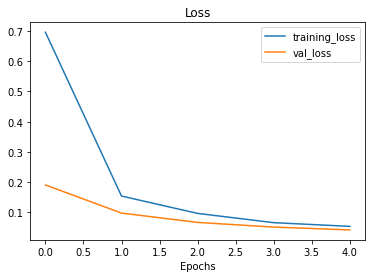

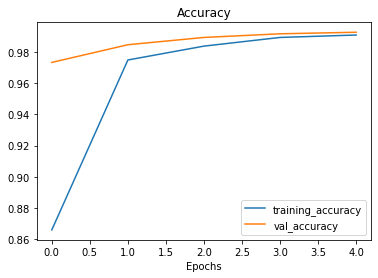

In [13]:
model_1 = tf.keras.Model(inputs, outputs)

model_1.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])



initial_epochs = 5
history_1 = model_1.fit(
    train_30_percent, 
    epochs = initial_epochs,
    steps_per_epoch=len(train_30_percent),
    validation_data=validation_data,
    validation_steps=len(validation_data),
    callbacks=[checkpoint_callback]
)
plot_loss_curves(history_1)

In [14]:
model_1_results = model_1.evaluate(test_data)

94/94 [==============================] - 7s 78ms/step - loss: 0.0452 - accuracy: 0.9917


In [15]:
model_1.save_weights(checkpoint_path)

* model_1 gives great results with 99% accuracy on the full test dataset
* model_1 only uses 30% of training data, we'll use the full training set once we fine tune the model

Since model_1 has good performance we'll checkpoint it to create the fine tuned models to squeeze a little more out of our model

## Model 2: Fine tuning


In [16]:
# Load in the model
model_2 = tf.keras.Model(inputs, outputs)
model_2.load_weights(checkpoint_path)

### Unfreeze layers

In [17]:
base_model.trainable = True

# Freeze all layers except the last 10
for layer in base_model.layers[:-10]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_2.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)



In [18]:
# Check which layers are trainable
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

## Fit the model

Epoch 5/10
94/94 [==============================] - 22s 232ms/step - loss: 0.2225 - accuracy: 0.9373 - val_loss: 0.0768 - val_accuracy: 0.9783
Epoch 6/10
94/94 [==============================] - 20s 216ms/step - loss: 0.0576 - accuracy: 0.9850 - val_loss: 0.0209 - val_accuracy: 0.9937
Epoch 7/10
94/94 [==============================] - 20s 209ms/step - loss: 0.0163 - accuracy: 0.9940 - val_loss: 0.0525 - val_accuracy: 0.9857
Epoch 8/10
94/94 [==============================] - 20s 214ms/step - loss: 0.0100 - accuracy: 0.9963 - val_loss: 0.0375 - val_accuracy: 0.9903
Epoch 9/10
94/94 [==============================] - 19s 206ms/step - loss: 0.0154 - accuracy: 0.9963 - val_loss: 0.0254 - val_accuracy: 0.9930
Epoch 10/10
94/94 [==============================] - 20s 209ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0273 - val_accuracy: 0.9920


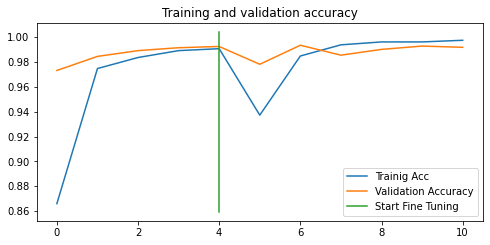

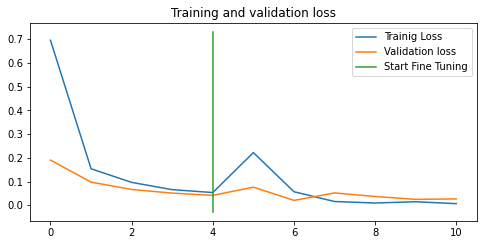

In [19]:

fine_tuned_epochs = initial_epochs + 5

history_2 = model_2.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_2)

In [20]:
model_2_results = model_2.evaluate(test_data)

94/94 [==============================] - 7s 79ms/step - loss: 0.0114 - accuracy: 0.9977


In [21]:
model_1_results, model_2_results

([0.045184798538684845, 0.9916666746139526],
 [0.011420974507927895, 0.9976666569709778])

* unfreezing some layers gave us a higher percentage although it's already high from model_1

lets try one more time and we'll unfreeze more layers (30)

## Model 3: Unfreeze more layers

In [22]:
model_3 = tf.keras.Model(inputs, outputs)
model_3.load_weights(checkpoint_path)

In [23]:
base_model.trainable = True

# Freeze all layers except the last 30
for layer in base_model.layers[:-30]:
  layer.trainable = False


# Recompile (We have to recompile our models every time we make a change)
model_3.compile(
  loss='categorical_crossentropy',
  # When fine tuning, you typically want to lower the learning rate by 10X
  optimizer=tf.keras.optimizers.Adam(0.0001),
  metrics=['accuracy']
)


### Fit the model


Epoch 5/10
94/94 [==============================] - 22s 233ms/step - loss: 0.4115 - accuracy: 0.9020 - val_loss: 0.1253 - val_accuracy: 0.9790
Epoch 6/10
94/94 [==============================] - 20s 210ms/step - loss: 0.0949 - accuracy: 0.9767 - val_loss: 0.0480 - val_accuracy: 0.9863
Epoch 7/10
94/94 [==============================] - 19s 204ms/step - loss: 0.0260 - accuracy: 0.9923 - val_loss: 0.0321 - val_accuracy: 0.9913
Epoch 8/10
94/94 [==============================] - 20s 209ms/step - loss: 0.0451 - accuracy: 0.9877 - val_loss: 0.0361 - val_accuracy: 0.9887
Epoch 9/10
94/94 [==============================] - 19s 204ms/step - loss: 0.0156 - accuracy: 0.9953 - val_loss: 0.0207 - val_accuracy: 0.9940
Epoch 10/10
94/94 [==============================] - 20s 210ms/step - loss: 0.0195 - accuracy: 0.9940 - val_loss: 0.0458 - val_accuracy: 0.9920


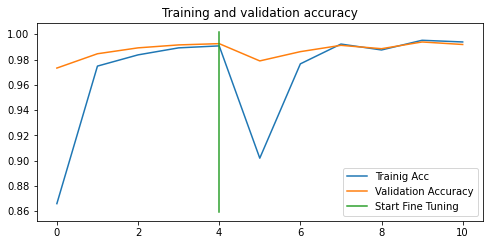

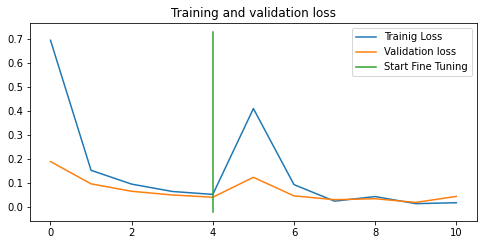

In [24]:
fine_tuned_epochs = initial_epochs + 5

history_3 = model_3.fit(
    test_data,
    epochs=fine_tuned_epochs,
    steps_per_epoch=len(test_data),
    validation_data=validation_data,
    validation_steps = len(validation_data),
    initial_epoch=history_1.epoch[-1]
)

compare_histories(history_1, history_3)

In [25]:
model_3_results = model_3.evaluate(test_data)

94/94 [==============================] - 7s 78ms/step - loss: 0.0232 - accuracy: 0.9967


# Compare Models

In [26]:
import pandas as pd
results = [model_1_results , model_2_results, model_3_results]
results_pd = pd.DataFrame(results, columns=['loss', 'accuracy'])
results_pd

,loss,accuracy
0,0.045185,0.991667
1,0.011421,0.997667
2,0.023162,0.996667


# Summary

from the start `EfficientNetB0` gave us a very high score with only 30% of the traning data_augmentation

`model_3` gives us the best accuracy score with 30 layers of the base model unfrozen and re-fitted on our custom data

In [27]:
model_3.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
data_augmentation_layer (Seq (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 15)                19215     
Total params: 4,068,786
Trainable params: 1,515,375
Non-trainable params: 2,553,411
_________________________________________________________________
